In [1]:
version_nb = "v6"

/Users/joachimjasmin/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Final dictionary => 2504 words
Dictionary => {'break': 269, 'first': 891, 'charge': 363, 'file': 877, 'russia': 1941, 'investigation': 1169, 'special': 2095, 'counsel': 518, 'robert': 1925, 'mueller': 1440, 'appear': 129, 'turn': 2336, 'something': 2076, 'scandal': 1960, 'official': 1516, 'accord': 11, 'cnn': 410, 'someone': 2075, 'may': 1364, 'well': 2444, 'take': 2213, 'custody': 555, 'day': 573, 'house': 1074, 'senate': 1996, 'seem': 1991, 'throw': 2269, 'republican': 1871, 'include': 1115, 'trump': 2329, 'call': 308, 'hillary': 1049, 'one': 1525, 'still': 2138, 'exclusive': 809, 'story': 2144, 'currently': 554, 'order': 1542, 'federal': 863, 'judge': 1218, 'office': 1514, 'would': 2482, 'comment': 429, 'however': 1076, 'say': 1957, 'plan': 1635, 'prepared': 1684, 'friday': 937, 'anyone': 120, 'soon': 2079, 'monday': 1422, 'source': 2084, 'unclear': 2352, 'appoint': 133, 'shortly': 2035, 'fire': 889, 'fbi': 858, 'director': 652, 'james': 1193, 'comey': 426, 'original': 1546, 'whethe

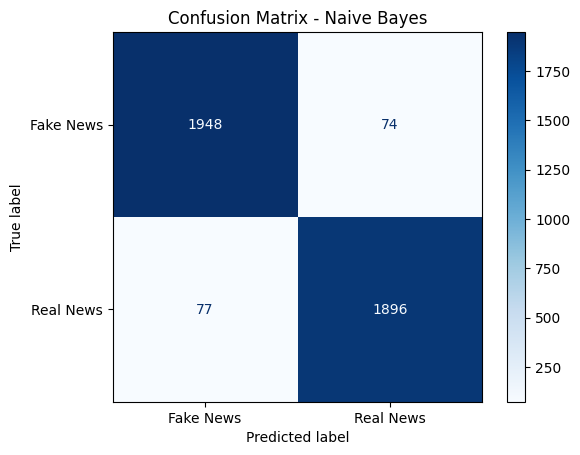

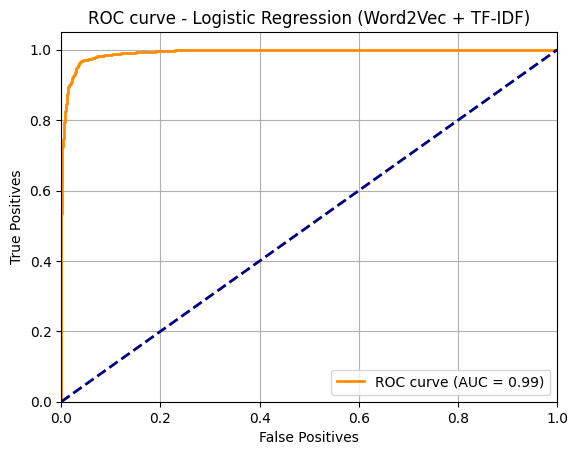

Validation predictions saved to ../data/validation_predictions_v6.csv


In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import re
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# ------------------------------------------------------------------ #
#                        Joined Data cleaning                        #
# ------------------------------------------------------------------ #

df = pd.read_csv("../../dataset/data.csv")

df['combined_text'] = df['title'] + ' ' + df['text'] + ' ' + df['subject']
df.drop(['title', 'text', 'subject', 'date'], axis=1, inplace=True)

# ------------------------------------------------------------------ #
#                          Train-Test Split                          #
# ------------------------------------------------------------------ #

y = df['label']
X = df.drop(['label'], axis=1)['combined_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# ------------------------------------------------------------------ #
#                           Pre-Processing                           #
# ------------------------------------------------------------------ #

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def pre_token_cleanup(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    return text

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0]
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocessing_pipeline(text):
    # Pre-token cleaning
    text = pre_token_cleanup(text)
    
    # Tokenization
    tokens = word_tokenize(text, language="english")
    
    # Cleaning steps
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    
    return tokens

X_train = X_train.apply(preprocessing_pipeline)
X_test = X_test.apply(preprocessing_pipeline)

# -------------------------------- . ------------------------------- #
# ------------------------- MODEL TRAINING ------------------------- #
# -------------------------------- . ------------------------------- #

import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pickle
import json

# ------------------------------------------------------------------ #
#                              Word2Vec                              #
# ------------------------------------------------------------------ #

w2v_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)

# ------------------------------------------------------------------ #
#                               TF-IDF                               #
# ------------------------------------------------------------------ #

def identity(x):
    return x

tfidf_vectorizer = TfidfVectorizer(
    analyzer=identity,
    min_df=0.01,
    max_df=0.9,
    ngram_range=(1, 3)
)

# We fit the pre-processed training data
tfidf_vectorizer.fit(X_train)

# Get weights
idf_weights = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

# Vizualize
print("Final dictionary =>", len(tfidf_vectorizer.vocabulary_), "words")
print("Dictionary =>", tfidf_vectorizer.vocabulary_)

# ------------------------------------------------------------------ #
#                              Embedding                             #
# ------------------------------------------------------------------ #

def get_weighted_embedding(tokens, model, idf_dict):
    vecs = []
    for word in tokens:
        if word in model.wv and word in idf_dict:
            vecs.append(model.wv[word] * idf_dict[word])
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(model.vector_size)
    
doc_embeddings_train = np.array([
    get_weighted_embedding(doc, w2v_model, idf_weights)
    for doc in X_train
])

doc_embeddings_test = np.array([
    get_weighted_embedding(doc, w2v_model, idf_weights)
    for doc in X_test
])

# Standardize embeddings
from sklearn.pipeline import make_pipeline
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
model.fit(doc_embeddings_train, y_train)

# scaler = StandardScaler()
# doc_embeddings_train = scaler.fit_transform(doc_embeddings_train)
# doc_embeddings_test = scaler.transform(doc_embeddings_test)

# ------------------------------------------------------------------ #
#                         Logistic Regression                        #
# ------------------------------------------------------------------ #

# Logistic Regression
# model = LogisticRegression(max_iter=1000, random_state=42)
# model.fit(doc_embeddings_train, y_train)
y_pred = model.predict(doc_embeddings_test)

# Prediction
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(y_test, y_pred, target_names=["Fake News", "Real News"])
print(report)

# ------------------------------------------------------------------ #
#                          Confusion Matrix                          #
# ------------------------------------------------------------------ #

cm = confusion_matrix(y_test, y_pred) # Labels (1 = Real News, 0 = fake News)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake News", "Real News"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# ------------------------------------------------------------------ #
#                              ROC Curve                             #
# ------------------------------------------------------------------ #


y_proba = model.predict_proba(doc_embeddings_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.title("ROC curve - Logistic Regression (Word2Vec + TF-IDF)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# ------------------------------------------------------------------ #
#                        Classification Report                       #
# ------------------------------------------------------------------ #

# Classification report
# print(classification_report(y_test, y_pred, target_names=["Fake News", "Real News"]))

# ------------------------------------------------------------------ #
#                            Model saving                            #
# ------------------------------------------------------------------ #

# Save the model
with open(f"../exports/model_{version_nb}.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the Word2Vec model
w2v_model.save(f"../exports/w2v_model_{version_nb}.model")

# Save the IDF dictionary
with open(f"../exports/idf_dict_{version_nb}.pkl", "wb") as f:
    pickle.dump(idf_weights, f)

# Save the scaler
# with open(f"../exports/scaler_{version_nb}.pkl", "wb") as f:
#     pickle.dump(scaler, f)

# Save the TfidfVectorizer
# with open(f"../exports/vect_{version_nb}.pkl", "wb") as f:
#     pickle.dump(tfidf_vectorizer, f)

# Save the metadata
metadata = {
    "model_name": f"model_{version_nb}",
    "vectorizer": "Word2Vec + TF-IDF (custom)",
    "accuracy": round(accuracy, 4),
    "date": "2025-05-24",
    "preprocessing": {
        "tokenization": "nltk word_tokenize",
        "stopwords": "NLTK english",
        "lemmatization": "WordNet POS-aware",
        "lowercase": True,
        "remove_punctuation": True
    },
    "vectorizer_params": str(tfidf_vectorizer.get_params()),
    "model_params": str(model.get_params())
}
with open(f"../exports/metadata_{version_nb}.json", "w") as f:
    json.dump(metadata, f, indent=4)

# ------------------------------------------------------------------ #
#                             Predicition                            #
# ------------------------------------------------------------------ #

from gensim.models import Word2Vec

with open(f"../exports/model_{version_nb}.pkl", "rb") as f:
    loaded_model = pickle.load(f)

w2v_model = Word2Vec.load(f"../exports/w2v_model_{version_nb}.model")

with open(f"../exports/idf_dict_{version_nb}.pkl", "rb") as f:
    idf_weights = pickle.load(f)

# with open(f"../exports/scaler_{version_nb}.pkl", "rb") as f:
#     scaler = pickle.load(f)
    
# Load val data
val_df = pd.read_csv("../../dataset/validation_data.csv")
val_df['combined_text'] = val_df['title'] + ' ' + val_df['text'] + ' ' + val_df['subject']
X_val = val_df['combined_text'].apply(preprocessing_pipeline)

doc_embeddings_val = np.array([
    get_weighted_embedding(doc, w2v_model, idf_weights)
    for doc in X_val
])

val_pred = loaded_model.predict(doc_embeddings_val)
val_df['predicted_label'] = val_pred
val_df.to_csv(f"../data/validation_predictions_{version_nb}.csv", index=False)
print(f"Validation predictions saved to ../data/validation_predictions_{version_nb}.csv")

In [5]:
coef = model.named_steps['logisticregression'].coef_[0]
coef

array([-0.06427707, -0.69916054, -0.42108679,  0.05563115,  0.04052184,
        0.05542669,  0.24768268, -0.43509125,  0.00843766,  1.97462072,
       -0.30924854,  0.69590611,  0.36293659, -0.1671236 ,  0.29677883,
       -0.13523309,  0.33225053,  0.63078552, -0.59445645,  0.29133021,
        0.09182751,  0.79235493,  0.18159381, -0.41871187,  0.46969231,
       -0.0357791 , -0.53322966, -0.63959006,  0.65686   ,  0.2284646 ,
       -0.39750267, -0.18322204, -0.34171253, -0.20757234,  0.10736324,
       -0.06858825, -0.32024346,  0.29062702, -0.44349699, -0.14626746,
       -1.18490164, -0.72970086, -0.29584791, -0.51502363,  1.06062043,
        0.85264688,  0.27541931,  1.2681392 , -0.21109562,  0.55946375,
       -0.42742459, -0.21242307,  0.2220017 ,  1.01082498,  0.22994723,
        0.53640716,  0.00278534, -0.70938669, -0.74409262, -0.0304852 ,
       -0.6310888 , -0.11329419, -0.23729104,  0.85988758, -0.23797509,
       -0.51327875, -0.05210673,  0.3621764 ,  0.05542242, -1.37

In [8]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, doc_embeddings_test, y_test, n_repeats=10, random_state=42)
importance_scores = result.importances_mean
importance_scores

array([ 1.37672090e-03,  7.05882353e-03,  5.10638298e-03, -1.75219024e-04,
       -1.50187735e-04,  4.75594493e-04,  1.85231539e-03,  3.50438048e-03,
       -2.50312891e-05,  4.76846058e-02,  2.32790989e-03,  8.78598248e-03,
        2.45306633e-03,  7.25907384e-04,  1.82728411e-03,  9.01126408e-04,
        2.27784731e-03,  4.88110138e-03,  7.33416771e-03,  2.25281602e-04,
        6.25782228e-04,  9.26157697e-03,  1.00125156e-04,  1.60200250e-03,
        3.07884856e-03,  2.00250313e-04,  6.28285357e-03,  8.43554443e-03,
        7.83479349e-03,  1.95244055e-03,  3.10387985e-03,  1.35168961e-03,
        2.90362954e-03,  8.26032541e-04,  3.50438048e-04,  1.00125156e-04,
        2.30287860e-03,  1.87734668e-03,  3.90488110e-03, -2.75344180e-04,
        2.16520651e-02,  8.66082603e-03,  1.67709637e-03,  4.13016270e-03,
        1.37421777e-02,  9.53692115e-03,  2.92866083e-03,  1.88235294e-02,
        1.77722153e-03,  5.10638298e-03,  4.75594493e-03,  7.50938673e-04,
        7.50938673e-04,  

In [9]:
%pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 1.0 MB/s eta 0:00:0000:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [11]:
import statsmodels.api as sm

logit_model = sm.Logit(y_train, sm.add_constant(doc_embeddings_train))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.100218
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                35947
Model:                          Logit   Df Residuals:                    35846
Method:                           MLE   Df Model:                          100
Date:                Sat, 24 May 2025   Pseudo R-squ.:                  0.8554
Time:                        15:18:40   Log-Likelihood:                -3602.5
converged:                       True   LL-Null:                       -24916.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9592      1.238      8.852      0.000       8.533      13.386
x1            -0.0353      0